In [32]:
import time
import sys
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [33]:
mnist_train = torchvision.datasets.FashionMNIST(root='./Datasets/FashionMNIST', train=True, download=True, transform=transforms.ToTensor())
mnist_test = torchvision.datasets.FashionMNIST(root='./Datasets/FashionMNIST', train=False, download=True, transform=transforms.ToTensor())

batch_size= 256
if sys.platform.startswith('win'):
    num_workers = 0     # 表示不用额外的进程来加速读取数据
else:
    num_workers = 4

train_iter = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_iter = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False, num_workers=num_workers)

### 3.6.2 初始化模型参数

已知每个样本输入是高和宽均为28像素的图像。模型的输入向量长度是28×28=784：该向量的每个元素对应图像中每个像素。由于图像有10个类别，单层神经网络输出层的输出个数为10，因此softmax回归的权重和偏差参数分别为784×10和1×10

In [34]:
num_inputs = 784
num_outputs = 10

W = torch.tensor(np.random.normal(0, 0.01, (num_inputs, num_outputs)), dtype=torch.float32)
b = torch.zeros(num_outputs, dtype=torch.float32)

In [35]:
# 设置模型参数梯度
W.requires_grad_(True)
b.requires_grad_(True)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)

### 3.6.3 实现softmax运算

给定一个`Tensor`矩阵`X`，可以只对其中同一列(`dim=0`)或同一行(`dim=1`)的元素求和，并在结果中保留行和列这两个维度(`keepdim=True`)

In [36]:
X = torch.tensor([[1, 2, 3], [4, 5, 6]])
print(X.sum(dim=0, keepdim=True))
print(X.sum(dim=1, keepdim=True))

tensor([[5, 7, 9]])
tensor([[ 6],
        [15]])


In [37]:
X.exp()

tensor([[  2.7183,   7.3891,  20.0855],
        [ 54.5981, 148.4132, 403.4288]])

在下面函数中，矩阵`X`的行数是样本数，列数是输出个数。

In [38]:
def softmax(X):
    X_exp = X.exp()
    partition = X_exp.sum(dim=1, keepdim=True)
    return X_exp / partition

In [39]:
# 查看效果，每行和为1
X = torch.randn(2, 2)
X_prob = softmax(X)
print(X_prob, X_prob.sum(dim=1))

tensor([[0.8360, 0.1640],
        [0.6016, 0.3984]]) tensor([1., 1.])


### 3.6.4 定义模型参数

In [40]:
def net(X):
    return softmax(torch.mm(X.view((-1, num_inputs)), W) + b)

### 3.6.5 定义损失函数

In [41]:
torch.gather?

Docstring:
gather(input, dim, index, *, sparse_grad=False, out=None) -> Tensor

Gathers values along an axis specified by `dim`.

For a 3-D tensor the output is specified by::

    out[i][j][k] = input[index[i][j][k]][j][k]  # if dim == 0
    out[i][j][k] = input[i][index[i][j][k]][k]  # if dim == 1
    out[i][j][k] = input[i][j][index[i][j][k]]  # if dim == 2

:attr:`input` and :attr:`index` must have the same number of dimensions.
It is also required that ``index.size(d) <= input.size(d)`` for all
dimensions ``d != dim``.  :attr:`out` will have the same shape as :attr:`index`.
Note that ``input`` and ``index`` do not broadcast against each other.

Args:
    input (Tensor): the source tensor
    dim (int): the axis along which to index
    index (LongTensor): the indices of elements to gather

Keyword arguments:
    sparse_grad (bool, optional): If ``True``, gradient w.r.t. :attr:`input` will be a sparse tensor.
    out (Tensor, optional): the destination tensor

Example::

    >>> t 

In [42]:
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])    # 预测概率
y = torch.LongTensor([0, 2])                                # 真实标签
print(y_hat.dtype)
print(y.dtype)

torch.float32
torch.int64


In [43]:
y.item()    # 将tensor转变为python标量，当且仅当tensor为标量时

ValueError: only one element tensors can be converted to Python scalars

In [44]:
# 使用torch.gather()找到真实标签对应的预测概率
y_hat.gather(1, y.view(-1, 1))

tensor([[0.1000],
        [0.5000]])

In [45]:
# 定义交叉熵损失函数
def cross_entropy(y_hat, y):
    return - torch.log(y_hat.gather(1, y.view(-1, 1)))

### 3.6.6 计算分类准确率

In [46]:
def accuracy(y_hat, y):
    return (torch.argmax(y_hat, dim=1) == y).float().mean().item()

In [47]:
accuracy(y_hat, y)

0.5

In [48]:
# 评价模型`net`在数据集`data_iter`上的准确率
def evaluate_accuracy(data_iter, net):
    acc_sum, n = 0.0, 0
    for X, y in data_iter:
        acc_sum += (torch.argmax((net(X)),1) == y).float().sum().item()
        n += y.shape[0]
    return acc_sum / n

In [49]:
evaluate_accuracy(test_iter, net)

0.098

### 3.6.7 训练模型

In [50]:
def sgd(params, lr, batch_size):
    for param in params:
        param.data -= lr * param.grad / batch_size

In [51]:
epochs = 5
lr = 0.1

def train_ch3(net, train_iter, test_iter, loss, epochs, batch_size,
            params=None, lr=None, optimizer=None):
    for epoch in range(epochs):
        train_l_sum, train_acc_sum, n = 0.0, 0.0, 0
        for X, y in train_iter:
            y_hat = net(X)
            l = loss(y_hat, y).sum()

            # 梯度清零
            if optimizer is not None:
                optimizer.zero_grad()
            elif params is not None and params[0].grad is not None:
                for param in params:
                    param.grad.data.zero_()
            
            l.backward()
            if optimizer is None:
                sgd(params, lr, batch_size)
            else:
                optimizer.step()
            
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(dim=1) == y).sum().item()
            n += y.shape[0]
        test_acc = evaluate_accuracy(test_iter, net)
        print('epoch %d, loss %.4f, train_acc %.3f, test acc %.3f'
            % (epoch+1, train_l_sum / n, train_acc_sum / n, test_acc))

train_ch3(net, train_iter, test_iter, cross_entropy, epochs, batch_size, [W, b], lr)

epoch 1, loss 0.7866, train_acc 0.749, test acc 0.789
epoch 2, loss 0.5716, train_acc 0.813, test acc 0.811
epoch 3, loss 0.5255, train_acc 0.825, test acc 0.815
epoch 4, loss 0.5024, train_acc 0.832, test acc 0.823
epoch 5, loss 0.4859, train_acc 0.837, test acc 0.827


In [52]:
# 将数值标签转换成相应的文本标签
def get_fashion_labels(labels):
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]


# 在一行里面画出多张图像和对应标签的函数。
def show_fashion_mnist(images, labels):
    _, figs = plt.subplots(1, len(images), figsize=(12, 12))
    for f, img, lbl in zip(figs, images, labels):
        f.imshow(img.view((28, 28)).numpy())
        f.set_title(lbl)
        f.axes.get_xaxis().set_visible(False)
        f.axes.get_yaxis().set_visible(False)
    plt.show()

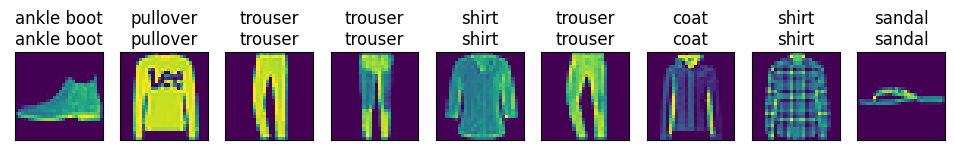

In [53]:
X, y = iter(test_iter).next()

true_labels = get_fashion_labels(y.numpy())
pred_labels = get_fashion_labels(net(X).argmax(dim=1).numpy())
title = [true + '\n' + pred for true, pred in zip(true_labels, pred_labels)]

show_fashion_mnist(X[0:9], title[0:9])